# Predicting Stock Prices using Multiple Linear Regression 
### Automating Lagged Regression at Multiple Confidence Intervals

In this tutorial learn to:
* Perform multiple linear regression using time-series analysis and lagged close price (auto-regression)
* Predict stock price at multiple time intervals in the future (e.g. 10 days out, 30 days out, 180 days out...)
* Calculate key statistics like R-squared, Standard Error, and Degrees of Freedom
* Compare price predictions across multiple confidence intervals (e.g. 95%, 99%)
* Do MLR on multiple stocks at the same time without using Excel or having to clean/wrangle data! 

Note: this tutorial assumes basic competence in Python and some knowledge of basic statistics

#### This is an advanced tutorial. For previous tutorials, please check:
* [How to Fetch Stock Data](https://github.com/yusifrefae/Jupyter-Projects/blob/main/fetch-stock-data.ipynb)
* [Stock Options Data Analysis](https://github.com/yusifrefae/Jupyter-Projects/blob/main/stock-options-data-analysis.ipynb)
* [Calculate Expected Move using Options](https://github.com/yusifrefae/Jupyter-Projects/blob/main/calculate-expected-move.ipynb)
* [Automating Two-Stage Dividend Growth Model](https://github.com/yusifrefae/Jupyter-Projects/blob/main/two-stage-growth-model.ipynb)

### Import Necessary Libaries

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date, datetime, timedelta
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy import stats

### Build a function to fetch historical price data from yfinance.
##### Limit the period of data to 100 years or less.

In [2]:
def get_close_price_df(symbol, years, interval):

    if years > 100:
            print(f'{years} is invalid. Years must be 100 or less.')
            return
    else:
        # Get historical data from yahoo based on user inputs
        df = yf.Ticker(symbol).history(start=datetime.now() - timedelta(days=365 * years),
                                       end=datetime.now(),
                                       interval=interval)
    
        # Reset index, keep only needed columns
        df = df.reset_index()[["Date", "Close"]]

        return df

### Fetch daily close price data for the last 100 years for Pfizer stock. The 'lagged' part we'll do later.

In [3]:
print(get_close_price_df('PFE', 100, '1d').head(3))
print()
print(get_close_price_df('PFE', 100, '1d').tail(3))

                       Date     Close
0 1972-06-01 00:00:00-04:00  0.151051
1 1972-06-02 00:00:00-04:00  0.149220
2 1972-06-05 00:00:00-04:00  0.148763

                           Date      Close
13451 2025-10-09 00:00:00-04:00  25.240000
13452 2025-10-10 00:00:00-04:00  24.780001
13453 2025-10-13 00:00:00-04:00  24.780001


#### Notice we have over 13,000 rows of data! Phew.

### Now let's create two new columns:
* ##### 'Lag' which is just a one-day delay of close price.
* ##### 'Trend' which is the same as the dataframe's index.

In [4]:
def get_lagged_close_price_df(symbol, years, interval):
    """Fetch historical stock data, create lagged 'Close' column, add a 'Trend' column, 
       and return a DataFrame with 'Date', 'Trend', 'Lag', and 'Close'."""
    if years > 100:
        print(f'{years} is invalid. Years must be 100 or less.')
        return
    else:
        # Get historical data from yahoo based on user inputs
        df = yf.Ticker(symbol).history(start=datetime.now() - timedelta(days=365 * years),
                                       end=datetime.now(),
                                       interval=interval)

        # Reset index, keep only needed columns
        df = df.reset_index()[["Date", "Close"]]
        ###############################################################
        
        # Create lagged column by shifting Close
        df['Lag'] = df['Close'].shift(1)
    
        # Drop first row with NaN in Lag
        df = df.iloc[1:].copy()
    
        # Create Trend starting at 0
        df['Trend'] = range(len(df))

        # Subtract one from index, so it matches Trend
        df.index = df.index - 1
        
        # Rearrange columns
        df = df[['Date', 'Trend', 'Lag', 'Close']]
    
        return df

In [5]:
df = get_lagged_close_price_df('PFE', 100, '1d')
df.head()

,Date,Trend,Lag,Close
0,1972-06-02 00:00:00-04:00,0,0.151051,0.149220
1,1972-06-05 00:00:00-04:00,1,0.149220,0.148763
2,1972-06-06 00:00:00-04:00,2,0.148763,0.151967
3,1972-06-07 00:00:00-04:00,3,0.151967,0.151967
4,1972-06-08 00:00:00-04:00,4,0.151967,0.151051


### Notice that the close price on day 0 equals the lag price on day 1, day 1 close = day 2 lag, etc... 
##### The lag price is always 'one day ahead' of the close price. It 'lags' behind the close price.
##### This is an autoregression or 'lagged' regression, so we expect the R-squared to be very high!

### Let's quickly visualize the first 90 days of data to demonstrate this relationship.
#### Notice how the graphs are exactly the same but 'offset' by a day. This is the lag.

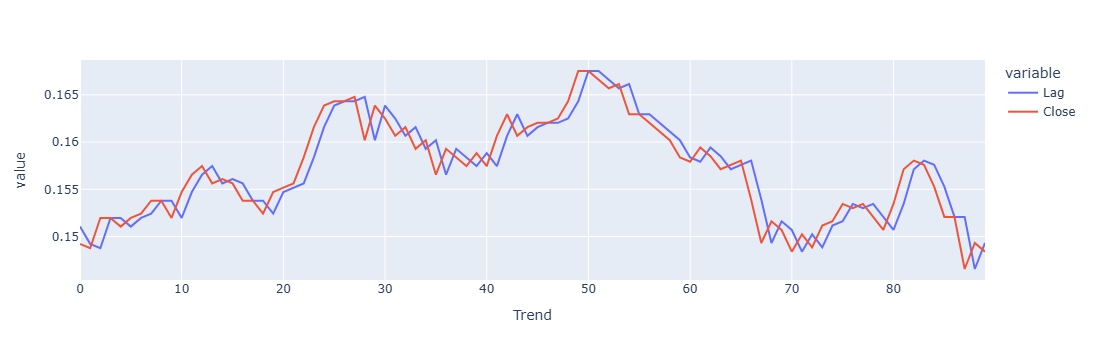

In [6]:
import plotly.express as px
px.line(df.head(90), x='Trend', y=['Lag', 'Close'])

### OK, now we've got our dataframe function defined. Let's dive into running the Multiple Linear Regression (MLR)

* #### The basic idea: In multiple linear regression, we have multiple independent (explanatory) variables.
* #### These multiple variables (multiple x's) explain a single dependent (response) variable (a single y).
* #### We use y-hat notation, because our y is a **prediction**, not an observation.
* #### For example, a medical study might use age, height, weight, and income to predict a likely health outcome or response to a drug.
* #### In our case, we're doing MLR with two independent variables (lagged price and trend) to try to explain and predict close price.

# General Multiple Linear Regression Formula
# $$ \hat{y} = m_0 + m_1 x_1 + m_2 x_2 + \cdots + m_n x_n $$
Where:  
- #### $\hat{y}$ is the predicted value (dependent variable)  
- #### $m_0$ is the intercept (constant term)  
- #### $m_1, m_2, \ldots, m_n$ are coefficients (slopes)  
- #### $x_1, x_2, \ldots, x_n$ are independent variables (features)
---
# Specific MLR Formula for Price Prediction
# $$ \hat{Price} = m_0 + m_1 \times Trend + m_2 \times Lagged\ Price $$
Where:  
- #### $\hat{Price}$ is the predicted stock price  
- #### $m_0$ is the intercept  
- #### $Trend$ is the trend indicator variable (i.e. which day in the series) 
- #### $Lagged\ Price$ is the previous day’s closing price (lag feature)  
- #### $m_1, m_2$ are the respective coefficients for Trend and Lagged Price

### In Python we can quickly and easily fit a linger regression model around our data

In [7]:
df_in = df

# Define two independent variables to use to predict Close Price
# Explicitly cast them as float variables
multiple_x = df_in[["Trend", "Lag"]].astype(float)
y =df_in["Close"].astype(float)

# Fit a model to the dataframe
model = LinearRegression()
model.fit(multiple_x, y)

# Add prediction and residuals columns based on regression equation: y = b0 + b1*Trend + b2*Lag
df_in["Y-Prediction"] = model.predict(multiple_x)
df_in["Residuals Squared"] = (y - df_in["Y-Prediction"]) ** 2    
df_in

,Date,Trend,Lag,Close,Y-Prediction,Residuals Squared
0,1972-06-02 00:00:00-04:00,0,0.151051,0.149220,0.144144,0.000026
1,1972-06-05 00:00:00-04:00,1,0.149220,0.148763,0.142318,0.000042
2,1972-06-06 00:00:00-04:00,2,0.148763,0.151967,0.141864,0.000102
3,1972-06-07 00:00:00-04:00,3,0.151967,0.151967,0.145067,0.000048
4,1972-06-08 00:00:00-04:00,4,0.151967,0.151051,0.145070,0.000036
...,...,...,...,...,...,...
13448,2025-10-07 00:00:00-04:00,13448,26.430000,26.270000,26.433217,0.026640
13449,2025-10-08 00:00:00-04:00,13449,26.270000,25.680000,26.273405,0.352129
13450,2025-10-09 00:00:00-04:00,13450,25.680000,25.240000,25.684091,0.197217
13451,2025-10-10 00:00:00-04:00,13451,25.240000,24.780001,25.244603,0.215855


### What the Model Does
The model finds the best-fitting line (or plane) through the data that minimizes the total squared residuals, effectively learning how Trend and Lag explain the Close price.

### Explanation of Model Output Columns
- **Y-Prediction**: The predicted Close price calculated by the regression model using the formula  
  ### $$\hat{y} = b_0 + b_1 \times Trend + b_2 \times Lag $$  
  It represents the model’s estimate of the Close price based on the input features.

- **Residuals Squared**: The squared difference between the actual Close price and the predicted value, calculated as  
  ### $$(y - \hat{y})^2$$
  This measures the error for each prediction — smaller values mean better accuracy.

# We can visualize predicted price vs actual close price over the first year of data
#### While it may seem that predicted price and close price are far apart, this is a difference of only about 1 cent.

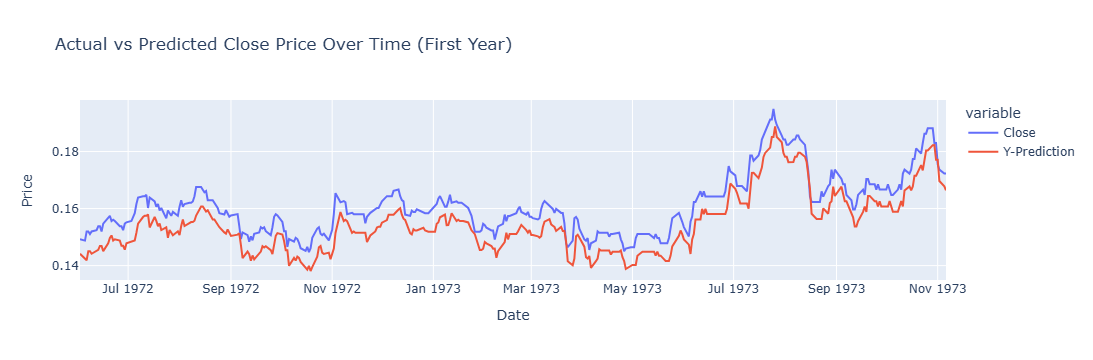

In [8]:
fig = px.line(df_in.head(360), x='Date', y=['Close', 'Y-Prediction'],
              labels={'value':'Price', 'Date':'Date'},
              title='Actual vs Predicted Close Price Over Time (First Year)')
fig.show()

### If we look at the last 90 days of data we can see the prediction is very close to the actual close price

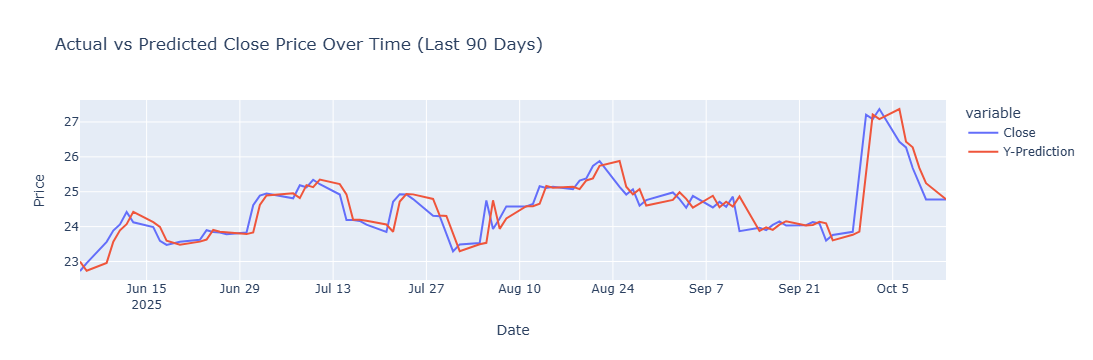

In [9]:
fig = px.line(df_in.tail(90), x='Date', y=['Close', 'Y-Prediction'],
              labels={'value':'Price', 'Date':'Date'},
              title='Actual vs Predicted Close Price Over Time (Last 90 Days)')
fig.show()

### Understanding Residuals
- Residuals represent the differences between the actual and predicted values — essentially, the errors of the model.
- If residuals show a **curvilinear or structured pattern**, it suggests the model isn’t capturing some relationship properly, so a linear model may not be appropriate.
- If residuals appear **randomly scattered with no obvious pattern or correlation**, it indicates the model fits the data reasonably well.


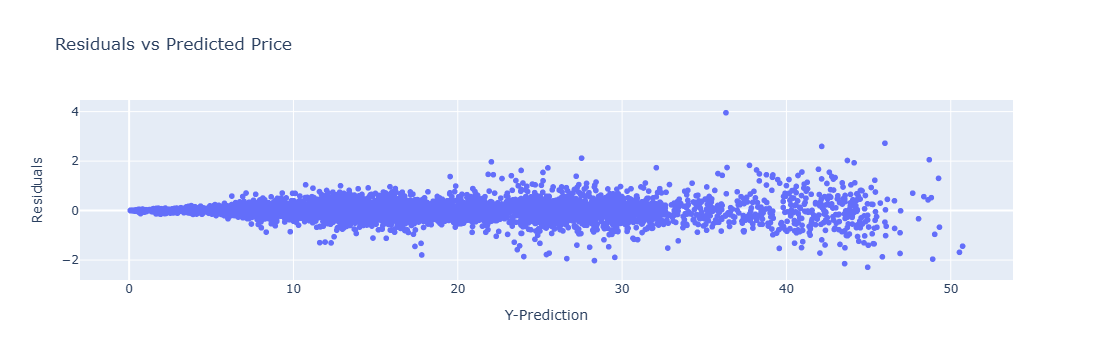

In [10]:
fig = px.scatter(df_in, x='Y-Prediction', y=(df_in["Close"] - df_in["Y-Prediction"]),
                 labels={'x':'Predicted Price', 'y':'Residuals'},
                 title='Residuals vs Predicted Price')
fig.show()

#### Notice that our residuals form a fat horizontal line. The errors appear to be random, so our model is likely a good fit.
#### An upward or downward sloping line or curvilinear pattern may imply the need for a polynominal or other non-linear model instead.

### Interpreting Residual Plots
- When residuals appear as a **fat horizontal band scattered evenly around zero**, it indicates **no correlation** between the residuals and the predicted prices.
- This pattern suggests that the residuals are **random and independent errors**, meaning the model is likely appropriate for the data.
- If residuals showed patterns (e.g., curves, funnels, or systematic trends), it would imply that a linear model may not be suitable.
- Therefore, a random horizontal scatter of residuals is a **good sign** that the linear regression model fits well.


# Let's start to define our MLR model function and get some key outputs from it

In [11]:
def do_MLR(df_in):
    # Define two independent variables to use to predict Close Price
    multiple_x = df_in[["Trend", "Lag"]].astype(float)
    y =df_in["Close"].astype(float)
    
    # Fit a model to the dataframe
    model = LinearRegression()
    model.fit(multiple_x, y)
        
    # Add prediction and residuals columns based on regression equation: y = b0 + b1*Trend + b2*Lag
    df_in["Y-Prediction"] = model.predict(multiple_x)
    df_in["Residuals Squared"] = (y - df_in["Y-Prediction"]) ** 2
    ################################################################################
    
    # Calculate  key output stats and put them into variables
    num_observ = len(df_in)
    y_int = model.intercept_
    trend_coeff = model.coef_[0]
    lag_coeff = model.coef_[1]
    r_sq = model.score(multiple_x, y)

    # Put statistical outputs into variables of MLR into single-row dataframe
    MLR_stats = pd.DataFrame({'Trend Coefficient': [trend_coeff],
                              'Lag Coefficient': [lag_coeff],
                              'Intercept': [y_int],
                              'R-Squared': [r_sq],
                              'Num Observ': [num_observ],
                             })
    return MLR_stats

In [12]:
df = get_lagged_close_price_df('PFE', 100, '1d')
do_MLR(df)

,Trend Coefficient,Lag Coefficient,Intercept,R-Squared,Num Observ
0,0.000003,0.998842,-0.006733,0.999523,13453


### Now we can write our predictive equation

### Predicted Stock Price = -0.006742 + (0.000003 x Trend) + (0.998842 x Lag Price)
* The R-squared value of 99.9% across 13k+ observations means our two independent variables explain almost 100% of the **dependent** variable (stock price).
* This is the equation used in the 'Y-Prediction' column of our previous dataframe

### Let's calculate degrees of freedom in order to calculate the mean standard error and adjusted R-squared

In [28]:
def do_MLR(df_in):
    # Define two independent variables to use to predict Close Price
    multiple_x = df_in[["Trend", "Lag"]].astype(float)
    y =df_in["Close"].astype(float)
    
    # Fit a model to the dataframe
    model = LinearRegression()
    model.fit(multiple_x, y)
        
    # Add prediction and residuals columns based on regression equation: y = b0 + b1*Trend + b2*Lag
    df_in["Y-Prediction"] = model.predict(multiple_x)
    df_in["Residuals Squared"] = (y - df_in["Y-Prediction"]) ** 2
    ################################################################################
    
    # Calculate  key output stats and put them into variables
    num_observ = len(df_in)
    y_int = model.intercept_
    trend_coeff = model.coef_[0]
    lag_coeff = model.coef_[1]
    r_sq = model.score(multiple_x, y)
    ################################################################################

    # Number of parameters (intercept + our two predictors: Trend and Lag)
    p = multiple_x.shape[1] + 1   
    
    # Residual degrees of freedom = n - p
    df_resid = num_observ - p

    # Exit function if small sample sizes result in  degrees of freedom might be 0 or less
    if df_resid <= 0:
        raise ValueError("Not enough observations for regression (n - p <= 0).")
    
    # standard error of estimate (SEE) using correct df
    std_error_estimate = np.sqrt(df_in["Residuals Squared"].sum() / df_resid)
    
    # adjusted R-squared (exact formula)
    adj_r_sq = 1 - ((1 - r_sq) * (num_observ - 1)) / df_resid    
    return p, df_resid, std_error_estimate, adj_r_sq

In [30]:
df = get_lagged_close_price_df('PFE', 100, '1d')
for i in range(0, 4):
    print(do_MLR(df)[i])

3
13450
0.23683161993007207
0.9995228911869473


We won’t dive too deep into statistical theory, but here’s the gist:

- Since we have two independent variables plus an intercept, the model has **3 parameters**.  
- Residual degrees of freedom = number of observations minus the number of parameters.  
- Residual degrees of freedom is important for calculating **Adjusted R-squared** and **Mean Squared Error (MSE)**.  
- **MSE** measures the average squared prediction error.  
- **Adjusted R-squared** shows model fit while accounting for the number of predictors.  
- In this case, because we only have two independent variables and are doing autoregression, **Adjusted R-squared** is almost the same as **R-squared**.

For reference, here are the formulas:
## Mean Squared Error (MSE)
# $$ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$
where:  
- $n$ = number of observations  
- $y_i$ = actual value  
- $\hat{y}_i$ = predicted value
---

## Adjusted R-squared
# $$ \text{Adjusted } R^2 = 1 - \left( \frac{(1-R^2)(n-1)}{n-p-1} \right) $$
where:  
- $R^2$ = coefficient of determination (R-squared)  
- $n$ = number of observations  
- $p$ = number of predictors (excluding intercept)

# Now for the fun part. Let's make some predictions. 

##### We specify a number of days to forecast into the future, let's use 30 days.
##### The model will give us (according to the predictive formula we got previously) the predicted price for each of the next 30 days! Cool.
##### We’re using the regression model to predict one day ahead, then using that prediction as an input to predict the next day, and so on...

In [31]:
def do_MLR(df_in, forecast_days):
    """Perform multiple linear regression to predict 'Close' using 'Trend' and 'Lag'. Output regression 
       dataframe and key MLR stats and stock price predictions at various confidence levels."""
    
    # Define two independent variables to use to predict Close Price
    multiple_x = df_in[["Trend", "Lag"]].astype(float)
    y =df_in["Close"].astype(float)
    
    # Fit a model to the dataframe
    model = LinearRegression()
    model.fit(multiple_x, y)
        
    # Add prediction and residuals columns based on regression equation: y = b0 + b1*Trend + b2*Lag
    df_in["Y-Prediction"] = model.predict(multiple_x)
    df_in["Residuals Squared"] = (y - df_in["Y-Prediction"]) ** 2
    ################################################################################
    
    # Calculate  key output stats and put them into variables
    num_observ = len(df_in)
    y_int = model.intercept_
    trend_coeff = model.coef_[0]
    lag_coeff = model.coef_[1]
    r_sq = model.score(multiple_x, y)
    ################################################################################

    # Number of parameters (intercept + our two predictors: Trend and Lag)
    p = multiple_x.shape[1] + 1   
    
    # Residual degrees of freedom = n - p
    df_resid = num_observ - p

    # Exit function if small sample sizes result in  degrees of freedom might be 0 or less
    if df_resid <= 0:
        raise ValueError("Not enough observations for regression (n - p <= 0).")
    
    # standard error of estimate (SEE) using correct df
    std_error_estimate = np.sqrt(df_in["Residuals Squared"].sum() / df_resid)
    
    # adjusted R-squared (exact formula)
    adj_r_sq = 1 - ((1 - r_sq) * (num_observ - 1)) / df_resid    
    ################################################################################

    # Use last observed 'Lag' as next input and next sequential 'Trend' value for prediction
    last_lag_price = float(df_in['Close'].iloc[-1])
    predicted_price = y_int + (trend_coeff * num_observ)  + (lag_coeff * last_lag_price)    
    ################################################################################

    # Predict for the next `forecast_days` (e.g., 30) days
    future_predictions = []
    future_lags = [float(df_in['Close'].iloc[-1])]  # Start with last 'Lag' value (last close price)
    future_trends = [num_observ]  # Start with current trend value (you can adjust if needed)
    
    for i in range(forecast_days):
        predicted_price = y_int + (trend_coeff * future_trends[-1]) + (lag_coeff * future_lags[-1])
        future_predictions.append(predicted_price)
    
        # Update for next prediction
        future_lags.append(predicted_price)  # Use predicted price as the next day's 'Lag'
        future_trends.append(future_trends[-1] + 1)  # Trend increments (you can adjust this logic)

    return future_predictions

In [39]:
df = get_lagged_close_price_df('PFE', 100, '1d')
for i in range(0, 30):
    print(f"Day {i + 1}: {do_MLR(df, 30)[i]: .2f}")

Day 1:  24.85
Day 2:  24.85
Day 3:  24.86
Day 4:  24.86
Day 5:  24.87
Day 6:  24.87
Day 7:  24.88
Day 8:  24.88
Day 9:  24.89
Day 10:  24.89
Day 11:  24.90
Day 12:  24.90
Day 13:  24.91
Day 14:  24.91
Day 15:  24.92
Day 16:  24.92
Day 17:  24.93
Day 18:  24.93
Day 19:  24.94
Day 20:  24.94
Day 21:  24.95
Day 22:  24.95
Day 23:  24.96
Day 24:  24.96
Day 25:  24.97
Day 26:  24.97
Day 27:  24.98
Day 28:  24.98
Day 29:  24.99
Day 30:  24.99


### We can predict the price 1 year from now and compare to the current market price

In [47]:
df = get_lagged_close_price_df('PFE', 100, '1d')
print(f"Current Price: {yf.Ticker('PFE').info.get('currentPrice'): .2f}")
print(f"1-Year Target Price: {do_MLR(df, 365)[364]: .2f}")

Current Price:  24.85
1-Year Target Price:  26.54


* PFE may or may not be a good investment, according to this model.
* To be sure, we should include **sensitivity analysis** and predict the price within a confidence level.

### Confidence Intervals for Price Predictions

To improve our investment decision, we calculate **confidence intervals** around the predicted prices. These intervals give us a range where the true price is likely to fall, with a certain level of confidence.

- We use **t-values** from the Student's t-distribution, which depend on the residual degrees of freedom (`df_resid`), to capture uncertainty in our estimates.
- For example, $t_{95}$ corresponds to the critical value for a **95% confidence level** (two-tailed), and $t_{99}$ corresponds to **99% confidence**.

Using these t-values, we compute the upper and lower bounds of the predicted price:

### $$ \text{Lower}_{95} = \hat{y} - t_{95} \times \text{SE} $$
### $$ \text{Upper}_{95} = \hat{y} + t_{95} \times \text{SE} $$
### $$ \text{Lower}_{99} = \hat{y} - t_{99} \times \text{SE} $$
### $$ \text{Upper}_{99} = \hat{y} + t_{99} \times \text{SE} $$


where:  
- $\hat{y}$ is the predicted price  
- $\text{SE}$ is the standard error estimate of the prediction

This range tells us that we can be 95% (or 99%) confident the true price will lie between the lower and upper bounds. Incorporating confidence intervals helps quantify the uncertainty and risk involved in the forecast.

In [65]:
def do_MLR(df_in, forecast_days, symbol):
    """Perform multiple linear regression to predict 'Close' using 'Trend' and 'Lag'. Output regression 
       dataframe and key MLR stats and stock price predictions at various confidence levels."""
    
    # Define two independent variables to use to predict Close Price
    multiple_x = df_in[["Trend", "Lag"]].astype(float)
    y =df_in["Close"].astype(float)
    
    # Fit a model to the dataframe
    model = LinearRegression()
    model.fit(multiple_x, y)
        
    # Add prediction and residuals columns based on regression equation: y = b0 + b1*Trend + b2*Lag
    df_in["Y-Prediction"] = model.predict(multiple_x)
    df_in["Residuals Squared"] = (y - df_in["Y-Prediction"]) ** 2
    ################################################################################
    
    # Calculate  key output stats and put them into variables
    num_observ = len(df_in)
    y_int = model.intercept_
    trend_coeff = model.coef_[0]
    lag_coeff = model.coef_[1]
    r_sq = model.score(multiple_x, y)
    ################################################################################

    # Number of parameters (intercept + our two predictors: Trend and Lag)
    p = multiple_x.shape[1] + 1   
    
    # Residual degrees of freedom = n - p
    df_resid = num_observ - p

    # Exit function if small sample sizes result in  degrees of freedom might be 0 or less
    if df_resid <= 0:
        raise ValueError("Not enough observations for regression (n - p <= 0).")
    
    # standard error of estimate (SEE) using correct df
    std_error_estimate = np.sqrt(df_in["Residuals Squared"].sum() / df_resid)
    
    # adjusted R-squared (exact formula)
    adj_r_sq = 1 - ((1 - r_sq) * (num_observ - 1)) / df_resid    
    ################################################################################

    # Use last observed 'Lag' as next input and next sequential 'Trend' value for prediction
    last_lag_price = float(df_in['Close'].iloc[-1])
    predicted_price = y_int + (trend_coeff * num_observ)  + (lag_coeff * last_lag_price)    
    ################################################################################

    # Predict for the next `forecast_days` (e.g., 30) days
    future_predictions = []
    future_lags = [float(df_in['Close'].iloc[-1])]  # Start with last 'Lag' value (last close price)
    future_trends = [num_observ]  # Start with current trend value (you can adjust if needed)
    
    for i in range(forecast_days):
        predicted_price = y_int + (trend_coeff * future_trends[-1]) + (lag_coeff * future_lags[-1])
        future_predictions.append(predicted_price)
    
        # Update for next prediction
        future_lags.append(predicted_price)  # Use predicted price as the next day's 'Lag'
        future_trends.append(future_trends[-1] + 1)  # Trend increments (you can adjust this logic)
    ################################################################################

    # Get t-values from scipy stats
    t95 = stats.t.ppf(0.975, df_resid)
    t99 = stats.t.ppf(0.995, df_resid)

    # Calculate upper and lower price predictions at 95% and 99% confidence levels
    lower_95 = predicted_price - t95 * std_error_estimate
    upper_95 = predicted_price + t95 * std_error_estimate
    lower_99 = predicted_price - t99 * std_error_estimate
    upper_99 = predicted_price + t99 * std_error_estimate
    ################################################################################
    
    # Put statistical outputs into variables of MLR into single-row dataframe
    MLR_stats = pd.DataFrame({'Trend Coefficient': [trend_coeff],
                              'Lag Coefficient': [lag_coeff],
                              'Intercept': [y_int],
                              'R-Squared': [r_sq],
                              'Num Observ': [num_observ],
                              'Std Error': [std_error_estimate],
                              'Adj R-Squared': [adj_r_sq],
                              'Predicted Price': [predicted_price],
                              'Lower 95': lower_95,
                              'Upper 95': upper_95,
                              'Lower 99': lower_99,
                              'Upper 99': upper_99,
                              'Mkt Price': yf.Ticker(symbol).info.get('currentPrice')
                             })

    df_predictions = pd.DataFrame({'Predicted Price': future_predictions}, index=range(1, forecast_days + 1))
    df_predictions.index.name = 'Day'
        
    return [df_in, MLR_stats, df_predictions]

### Let's take a look at the stats output dataframe, which includes our upper/lower predictions

In [66]:
symbol = 'PFE'
df = get_lagged_close_price_df(symbol, 100, '1d')
df_out = do_MLR(df, 30, symbol)[1].T  # Transpose the DataFrame
df_out.columns = [symbol]     # Rename the columns to a list containing symbol
df_out                        

,PFE
Trend Coefficient,0.000003
Lag Coefficient,0.998842
Intercept,-0.006750
R-Squared,0.999523
Num Observ,13453.000000
Std Error,0.236833
Adj R-Squared,0.999523
Predicted Price,25.025614
Lower 95,24.561388
Upper 95,25.489840


### We can predict with 95% confidence PFE will be between 24.55 and 25.48 in the next 30 days
### We can predict with 99% confidence PFE will be between 24.40 and 25.63 in the next 30 days
* Notice that as prediction accuracy increases, so does the price range
* Lower 95 and Lower 99 are both **below** the current market price, so we'd need to assess that risk further before investing

### Let's predict the price 1 year from now

In [68]:
df_out = do_MLR(df, 365, symbol)[1].T
df_out.columns = [symbol]    
df_out                        

,PFE
Trend Coefficient,0.000003
Lag Coefficient,0.998842
Intercept,-0.006750
R-Squared,0.999523
Num Observ,13453.000000
Std Error,0.236833
Adj R-Squared,0.999523
Predicted Price,26.557403
Lower 95,26.093177
Upper 95,27.021628


#### The model implies that for a short-term (30-day) investment, PFE may or may not yield a return on investment
#### But for a medium-term (1-year) investment, it's almost certain to be above the current market price at the end of the period.

### We can use this model to predict multiple prices across the entire indstury, all at once, dynamically. 
### Let's do 90 days.

In [72]:
days = 90
symbols = ['PFE', 'JNJ', 'MRK', 'ABBV', 'BMY', 'AMGN', 'GILD', 'LLY', 'REGN', 'VRTX']
combined_df = None

for symbol in symbols:
    df = get_lagged_close_price_df(symbol, 100, '1d')
    df_out = do_MLR(df, days, symbol)[1].T
    df_out.columns = [symbol]
    
    if combined_df is None:
        combined_df = df_out
    else:
        # Join on index, keep all rows
        combined_df = combined_df.join(df_out, how='outer')

combined_df

,PFE,JNJ,MRK,ABBV,BMY,AMGN,GILD,LLY,REGN,VRTX
Adj R-Squared,0.999523,0.999811,0.999672,0.999088,0.999535,0.999566,0.999443,0.999449,0.999411,0.999292
Intercept,-0.006746,-0.010394,-0.011093,-0.009254,-0.011093,-0.051855,-0.024491,-0.059218,-0.203641,-0.094608
Lag Coefficient,0.998842,1.000042,0.999582,0.998006,0.998913,0.999363,0.999112,1.000394,0.998891,0.999148
Lower 95,24.836730,193.460292,85.132037,231.528669,43.425527,290.968166,115.950507,862.481995,555.617742,401.797665
Lower 99,24.690829,193.068909,84.841294,230.566641,43.182725,289.932686,115.522372,860.210985,551.615020,399.838047
Mkt Price,24.855000,191.130000,85.885000,232.640000,43.615000,293.710000,117.580000,827.940000,554.040000,407.800000
Num Observ,13453.000000,16052.000000,16052.000000,3214.000000,13453.000000,10664.000000,8491.000000,13453.000000,8696.000000,8617.000000
Predicted Price,25.300955,194.705624,86.057148,234.587497,44.198067,294.262630,117.312557,869.707814,568.351948,408.031949
R-Squared,0.999523,0.999811,0.999673,0.999089,0.999535,0.999566,0.999443,0.999450,0.999412,0.999292
Std Error,0.236832,0.635337,0.471968,1.560067,0.394125,1.680689,0.694837,3.686378,6.496259,3.180369


### We can slice to quickly assess predicted prices relative to market prices

In [74]:
selected_df = combined_df.loc[['Lower 95', 'Lower 99', 'Upper 95', 'Upper 99', 'Mkt Price']]
selected_df

,PFE,JNJ,MRK,ABBV,BMY,AMGN,GILD,LLY,REGN,VRTX
Lower 95,24.836730,193.460292,85.132037,231.528669,43.425527,290.968166,115.950507,862.481995,555.617742,401.797665
Lower 99,24.690829,193.068909,84.841294,230.566641,43.182725,289.932686,115.522372,860.210985,551.615020,399.838047
Upper 95,25.765180,195.950956,86.982258,237.646325,44.970608,297.557095,118.674608,876.933632,581.086154,414.266232
Upper 99,25.911082,196.342338,87.273002,238.608353,45.213410,298.592574,119.102742,879.204642,585.088876,416.225851
Mkt Price,24.855000,191.130000,85.885000,232.640000,43.615000,293.710000,117.580000,827.940000,554.040000,407.800000


### We can visualize these prices as spectra to get a sense for what's potentially undervalued and overvalued

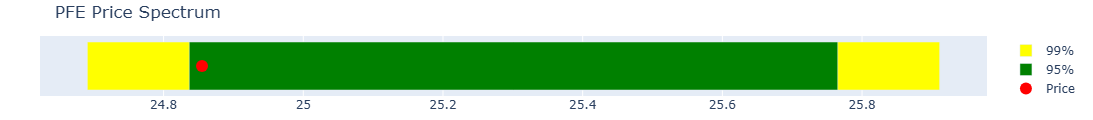

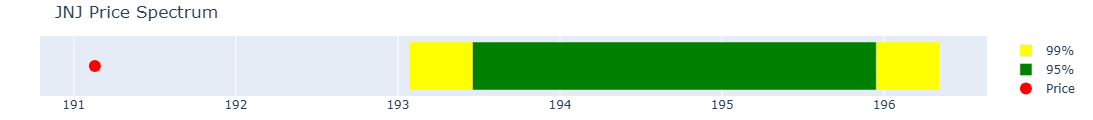

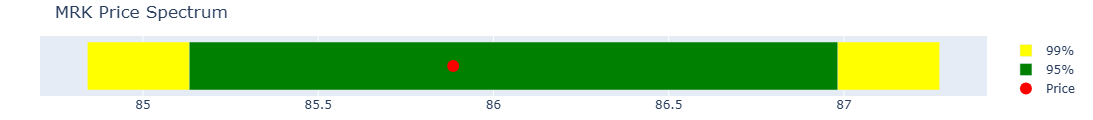

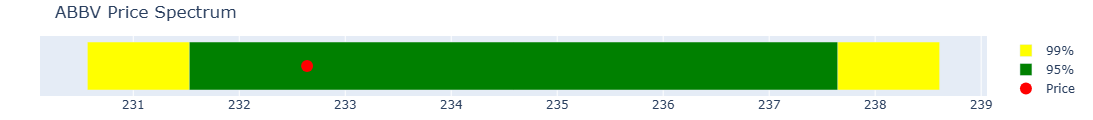

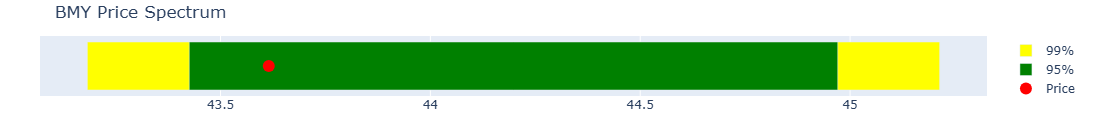

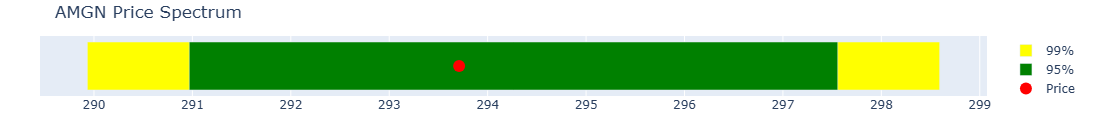

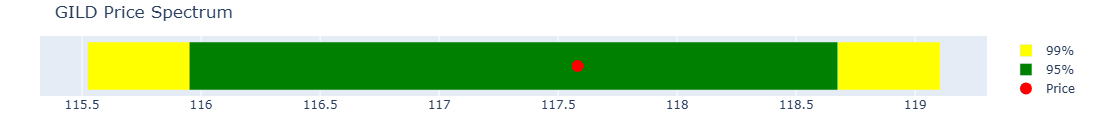

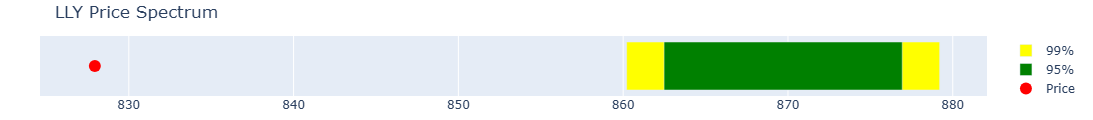

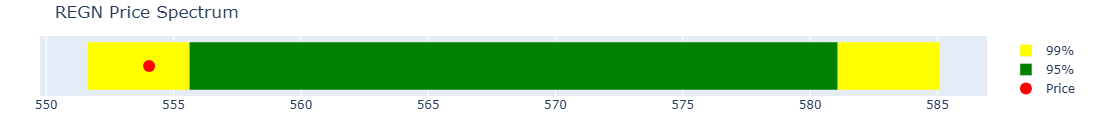

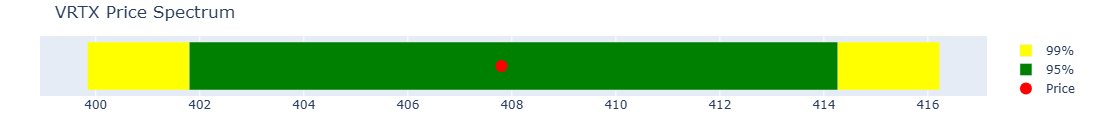

In [88]:
import plotly.graph_objects as go

for s in selected_df.columns:
    l99, l95 = selected_df.loc['Lower 99', s], selected_df.loc['Lower 95', s]
    u95, u99 = selected_df.loc['Upper 95', s], selected_df.loc['Upper 99', s]
    price = selected_df.loc['Mkt Price', s]

    fig = go.Figure([
        go.Bar(x=[u99 - l99], base=l99, y=[s], orientation='h', name='99%', marker_color='yellow'),
        go.Bar(x=[u95 - l95], base=l95, y=[s], orientation='h', name='95%', marker_color='green'),
        go.Scatter(x=[price], y=[s], mode='markers', name='Price', marker=dict(color='red', size=12))
    ])

    fig.update_layout(
        title=f'{s} Price Spectrum',
        barmode='overlay',
        #xaxis_title='Price',
        yaxis_visible=False,
        height=120,
        margin=dict(t=40, b=20, l=40, r=20),
        #legend=dict(orientation='h', x=0.5, xanchor='center', y=1.2)
    )

    fig.show()


#### PFE, JNJ, LLY, REGN seem undervalued and may be worth examining further for investment .
#### The industry as a whole seems to range from undervalued to fairly valued
#### It seems obvious there ISN'T a bubble (based on this particular model)

## Author: Yusif Refae, MBA
#### Let's work together: <a href = "https://www.linkedin.com/in/yusifrefae/">Message me on LinkedIn!</a>